# Plot the features of different categories of films
Chiefly used to examine movies based off books or sequels in comparison to all other films. Examination of features like revenue support the idea that the decision whether to finance book/sequel-based films vs all other film types is an important one faced by production companies.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import json 
import os
sns.set(style="whitegrid")

In [2]:
pd.options.display.max_rows = 10
# plot colours
sns.set_palette('muted', n_colors=5, desat=None, color_codes=False)
import sys
sys.path.insert(0, os.path.abspath('../utils/')) #point this to the where util is relatively to your working directory
from util import *

In [3]:
data_dir = get_path_to_data_dir()
plot_dir = get_path_to_plot_dir()
# movie_encoded_only_numeric same df as for modelling
df_ohe_bookcombined = pd.read_pickle(data_dir+"pre-processed/movie_encoded_only_numeric.pkl")
# ...bookcombined_date still has full release date info
df_withreleasedate = pd.read_pickle(data_dir+"pre-processed/movie_encoded_all.pkl")
#because release date has been removed / edited in future pkl files using a 

In [4]:
# get useful indices
book_inds = df_ohe_bookcombined.index[df_ohe_bookcombined['book']==1]
sequel_inds = df_ohe_bookcombined.index[df_ohe_bookcombined['sequel']==1]
notbook_notsequel_inds = df_ohe_bookcombined.index[(df_ohe_bookcombined['book']!=1) & (df_ohe_bookcombined['sequel']!=1)]

book_inds_releasedate = df_withreleasedate.index[df_withreleasedate['book']==1]
sequel_inds_releasedate = df_withreleasedate.index[df_withreleasedate['sequel']==1]
notbook_notsequel_releasedate_inds = df_withreleasedate.index[(df_withreleasedate['book']!=1) & (df_withreleasedate['sequel']!=1)]



# Motivation for the question
## Are more films being released based off books / are sequels?
From 2000 onwards, there has been a gradual increase in the number of films released that are based on books or that are sequels of previous films

In [5]:
df_datetime = df_withreleasedate["release_date"].astype("datetime64")

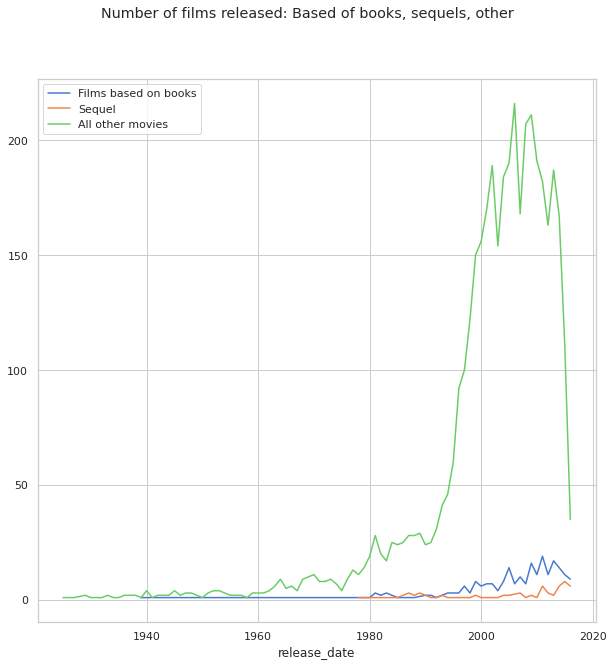

In [6]:
# Figure showing an the increase in movies based off books and sequels
#df.groupby([df["date"].dt.year, df["date"].dt.month]).count().plot(kind="bar")
f, (axes) = plt.subplots(1,1, figsize=(10,10))


df_datetime.groupby([df_datetime.iloc[book_inds_releasedate].dt.year]).count().plot(kind="line", ax=axes)

df_datetime.groupby([df_datetime.iloc[sequel_inds_releasedate].dt.year]).count().plot(kind="line", ax=axes)
df_datetime.groupby([df_datetime.iloc[notbook_notsequel_releasedate_inds].dt.year]).count().plot(kind="line", ax=axes)

axes.legend(["Films based on books", "Sequel", "All other movies"]);
f.suptitle('Number of films released: Based of books, sequels, other')
plt.savefig(plot_dir+"categoryplots_releasedate_books-sequels-other.png")


Tailing off of values for all these different movie categories - presumably due to data being collected mid-year leading to a sudden big drop?

## Do films based off books or sequels earn as much revenue as other films?

Although there are much fewer movies classified as based off a book or sequels, they definitely include movies which can earn as much as all other films.



In [7]:
# scale revenue for interpretability
scalefactor = 1000000
revenue_scaled = df_ohe_bookcombined['revenue']/scalefactor

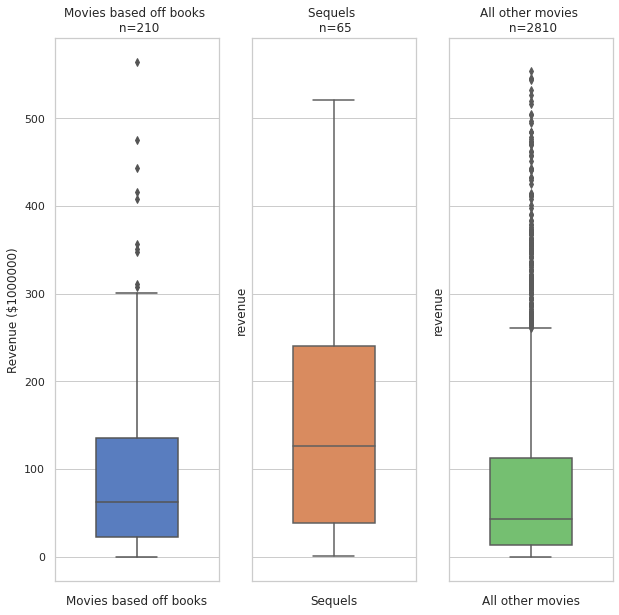

In [8]:
# what about the revenue distributions of these different groups...
#NB trimmed data
f, (axes) = plt.subplots(1,3, figsize=(10,10), sharey=True)
sns.boxplot(y=revenue_scaled.loc[book_inds],
                 width=0.5,
                 color=sns.color_palette()[0],ax=axes[0])
sns.boxplot( y = revenue_scaled.loc[sequel_inds],
                 width=0.5,
                 color=sns.color_palette()[1],ax=axes[1])
sns.boxplot( y=revenue_scaled.loc[notbook_notsequel_inds],
                 width=0.5,
                 color=sns.color_palette()[2], ax=axes[2])
axes[0].set_ylabel('Revenue ($%d)' % (scalefactor))

axes[0].set_xlabel('Movies based off books')
axes[1].set_xlabel('Sequels')
axes[2].set_xlabel('All other movies')

axes[0].set_title('Movies based off books \n n=%d' % (len(book_inds)))
axes[1].set_title('Sequels \n n=%d' % (len(sequel_inds)))
axes[2].set_title('All other movies \n n=%d' % (len(notbook_notsequel_inds)))
plt.savefig(plot_dir+"categoryplots_revenue-boxplot_books-sequels-other.png")

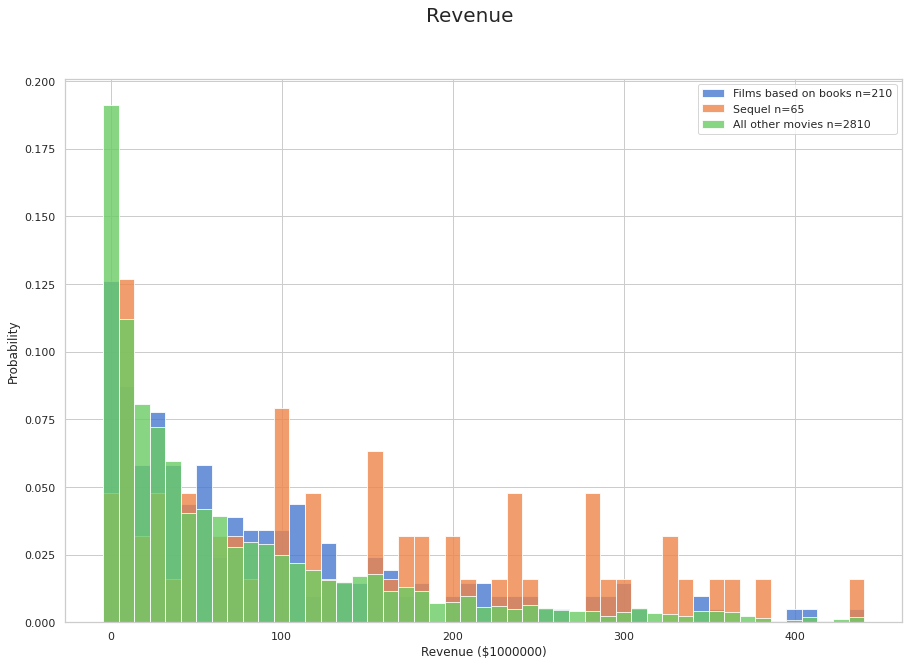

In [9]:
#Histograms for choice...
quantz = [0.01, 0.99]
numbins = 50
alphaval=0.8
bedges = revenue_scaled.quantile([quantz[0], quantz[1]])
bedges = np.linspace(bedges[quantz[0]],bedges[quantz[1]],numbins)

f, (axes) = plt.subplots(1,1, figsize=(15,10))
hist, bins = np.histogram(revenue_scaled.loc[book_inds],
                         bins=bedges)
axes.bar(bins[:-1], hist.astype(np.float32) / hist.sum(), width=(bins[1]-bins[0]),
        alpha=alphaval)

hist, bins = np.histogram(revenue_scaled.loc[sequel_inds], 
                          bins=bedges)
axes.bar(bins[:-1], hist.astype(np.float32) / hist.sum(), width=(bins[1]-bins[0]),
        alpha=alphaval)

hist, bins = np.histogram(revenue_scaled.loc[notbook_notsequel_inds],
                         bins=bedges)
axes.bar(bins[:-1], hist.astype(np.float32) / hist.sum(), width=(bins[1]-bins[0]),
        alpha=alphaval)
axes.set_xlabel('Revenue ($%d)' % (scalefactor))
axes.set_ylabel('Probability')
f.suptitle('%s' % ('Revenue'), fontsize=20)
axes.legend(["Films based on books n=%d" % (len(book_inds)), 
            "Sequel n=%d" % (len(sequel_inds)),
            "All other movies n=%d" % (len(notbook_notsequel_inds))]);
plt.savefig(plot_dir+"categoryplots_revenue-normhist_books-sequels-other.png")

### Earlier plots below complete feature engineering
Early plots before feature engineering was complete. These show some early examination of movies based on novels before Ivan grouped them in his feature engineering.

In [10]:
# Considering using "profit" calculated as revenue-budget as a measure of success.
# But requires removal of movies with no budget...
# Remove movies which have no budget
movie_details_neat = pd.read_pickle(data_dir + 'pre-processed/movie_details_neat.pkl')
# when other commits are in change this to use trimmed dataframe
movie_details_neat_trimmed = movie_details_neat[movie_details_neat['budget'] !=0]

#calculate profit
movie_details_neat_trimmed['profit'] = movie_details_neat_trimmed['revenue'] - movie_details_neat_trimmed['budget']

/home/klc116/.local/share/virtualenvs/datatonic-challenge-vXlODfEJ/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [11]:
movie_details_neat_trimmed.head()

,budget,id,popularity,revenue,runtime,vote_average,vote_count,genres,keywords,original_language,original_title,overview,production_companies,production_countries,release_date,spoken_languages,movie_id,cast,crew,profit
0,105000000,64682,61.196071,351040419,143.0,7.3,3769,"{'id': [18, 10749], 'name': ['Drama', 'Romance']}","{'id': [818, 1326, 1523, 3929, 209714], 'name'...",en,The Great Gatsby,An adaptation of F. Scott Fitzgerald's Long Is...,"{'name': ['Village Roadshow Pictures', 'Bazmar...","{'iso_3166_1': ['US', 'AU'], 'name': ['United ...",2013-05-10,"{'iso_639_1': ['en'], 'name': ['English']}",64682,"{'cast_id': [2, 5, 3, 8, 6, 4, 7, 22, 13, 23, ...","{'credit_id': ['52fe46e3c3a368484e0a982d', '52...",246040419
1,150000000,9543,62.169881,335154643,116.0,6.2,2317,"{'id': [12, 14, 28, 10749], 'name': ['Adventur...","{'id': [1241, 1965, 12653, 12654, 12655, 41645...",en,Prince of Persia: The Sands of Time,A rogue prince reluctantly joins forces with a...,"{'name': ['Walt Disney Pictures', 'Jerry Bruck...","{'iso_3166_1': ['US'], 'name': ['United States...",2010-05-19,"{'iso_639_1': ['en'], 'name': ['English']}",9543,"{'cast_id': [5, 2, 7, 4, 6, 8, 9, 10, 26, 27, ...","{'credit_id': ['567e74d4c3a36860e9008e46', '52...",185154643
2,140000000,5174,22.571780,258022233,91.0,6.1,783,"{'id': [28, 35, 80, 53], 'name': ['Action', 'C...","{'id': [1704], 'name': ['ambassador']}",en,Rush Hour 3,After an attempted assassination on Ambassador...,"{'name': ['New Line Cinema'], 'id': [12]}","{'iso_3166_1': ['US'], 'name': ['United States...",2007-08-08,"{'iso_639_1': ['la', 'en', 'fr', 'ja', 'zh'], ...",5174,"{'cast_id': [2, 3, 4, 5, 6, 7, 8, 9, 26, 27, 2...","{'credit_id': ['52fe43fac3a36847f807b5bd', '52...",118022233
3,145000000,1735,60.034162,401128639,112.0,5.2,1387,"{'id': [12, 28, 14], 'name': ['Adventure', 'Ac...",{},en,The Mummy: Tomb of the Dragon Emperor,"Archaeologist Rick O'Connell travels to China,...","{'name': ['Universal Pictures', 'China Film Co...","{'iso_3166_1': ['DE', 'US'], 'name': ['Germany...",2008-07-01,"{'iso_639_1': ['en', 'zh', 'sa'], 'name': ['En...",1735,"{'cast_id': [1, 2, 8, 12, 13, 14, 15, 16, 17, ...","{'credit_id': ['52fe4312c3a36847f80384c5', '52...",256128639
4,27000000,79698,2.418535,0,109.0,4.8,34,"{'id': [28, 12, 878, 10749], 'name': ['Action'...",{},en,The Lovers,The Lovers is an epic romance time travel adve...,"{'name': ['Corsan', 'Bliss Media', 'Limelight ...","{'iso_3166_1': ['AU', 'BE', 'IN'], 'name': ['A...",2015-02-13,"{'iso_639_1': ['en'], 'name': ['English']}",79698,"{'cast_id': [11, 13, 22, 17, 14, 15, 16, 18, 1...","{'credit_id': ['52fe49e0c3a368484e145067', '57...",-27000000


In [12]:
#getting maps for the keywords 'books based on a novel'
with open(data_dir + 'pre-processed/id_maps.json', 'r') as f:
    id_maps = json.load(f)

In [13]:
#find the keywords that would allow us to pick out movies based off books (for example)
def idmap_searcher(id_map_key, kws):
    idz = []
    for query_string in kws:
        for id in id_maps[id_map_key]:
            if id_maps[id_map_key][id].find(query_string) != -1:
                idz.append(id)
                print(id_maps['keywords'][id], id)

In [14]:
# what keywords contain novel?
idmap_searcher('keywords', ['novel'])

based on novel 818
based on graphic novel 18712
based on young adult novel 223438
novelist 155251
stolen novel 180405
plagiarized novel 180412
crime novelist 185767


From the above cell it appears that important keywords to identify movies based off books are: 818, 18712, 223438.
We will keep track of this for producing the following plots:

In [15]:
#dictionary with format: Key = id_map/column name being used to categorise movies
collect_these = {'keywords': [818, 18712, 223438]}

### Plot comparing budget and popularity of films based off books. 
The plot below shows that we significantly reduce the sample size of the data when we only consider films adapted from books. For films based on a novel, the average popularity score is low (28/100) but with a high standard deviation. Young adult novels which inspire movies seem to be more popular, with an average of 36/100. 

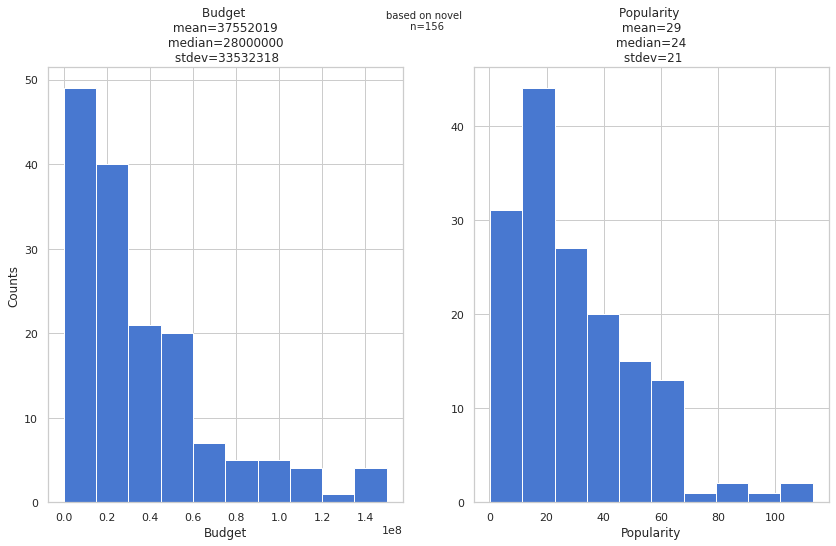

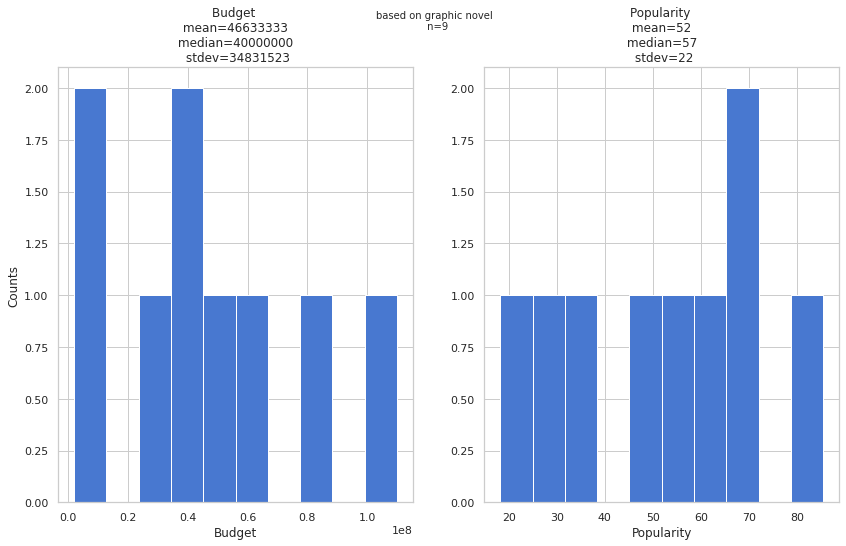

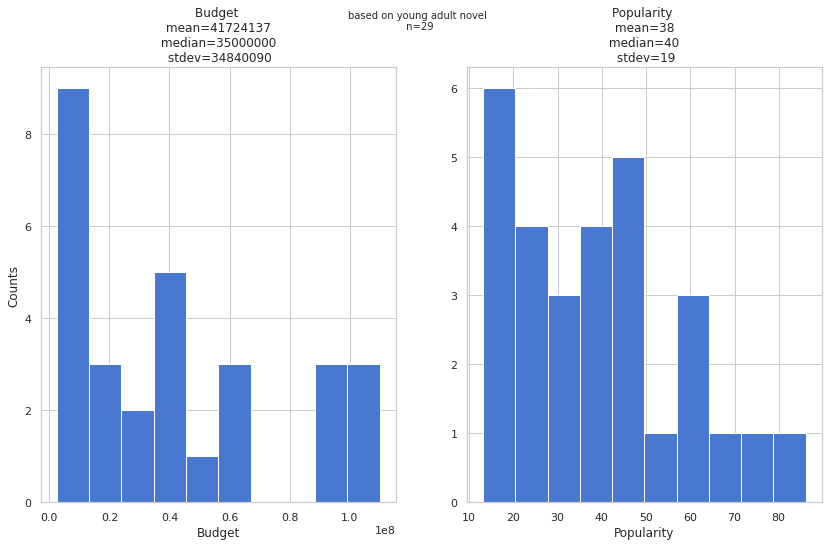

In [16]:
# To start: plots of revenue and popularity for each keyword
movie_details_neat_trimmed_dict = movie_details_neat_trimmed.to_dict('records')

for collect_type in collect_these.keys():
    for x in collect_these[collect_type]:
        thisgenre_df = retrieve_category(movie_details_neat_trimmed_dict, collect_type, x, 'id', save_dir=plot_dir)
    
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,8))
        ax1 = thisgenre_df['budget'].hist(ax=ax1)
        ax1.set_title('Budget \n mean=%d \n median=%d \n stdev=%d' % (thisgenre_df['budget'].mean(), thisgenre_df['budget'].median(), thisgenre_df['budget'].std()))
        ax1.set_ylabel('Counts')
        ax1.set_xlabel('Budget')

        
        ax2 = thisgenre_df['popularity'].hist(ax=ax2)
        ax2.set_title('Popularity \n mean=%d \n median=%d \n stdev=%d' % (thisgenre_df['popularity'].mean(), thisgenre_df['popularity'].median(), thisgenre_df['popularity'].std()))
        ax2.set_xlabel('Popularity')
        
        f.suptitle('%s \n n=%d' % (id_maps[collect_type][str(x)], len(thisgenre_df)), fontsize=10)
        plt.savefig(plot_dir+"category_plots_for_novel_budget_popularity.png")
    


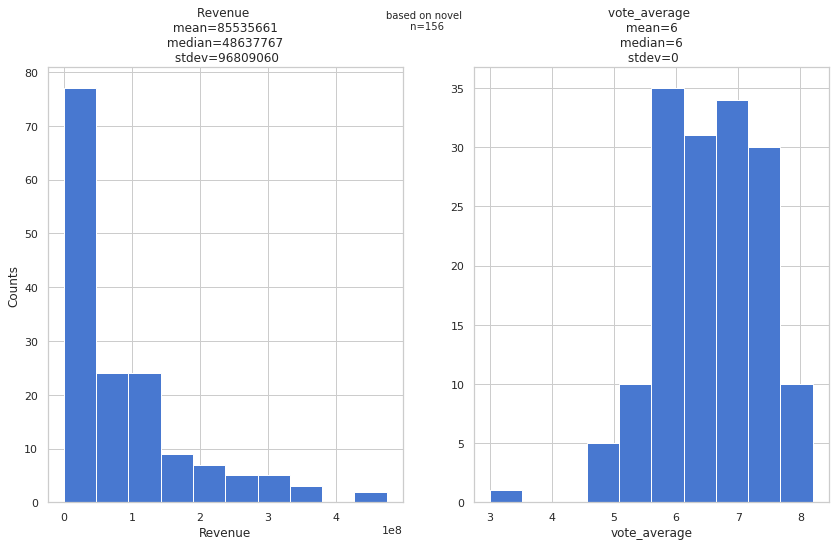

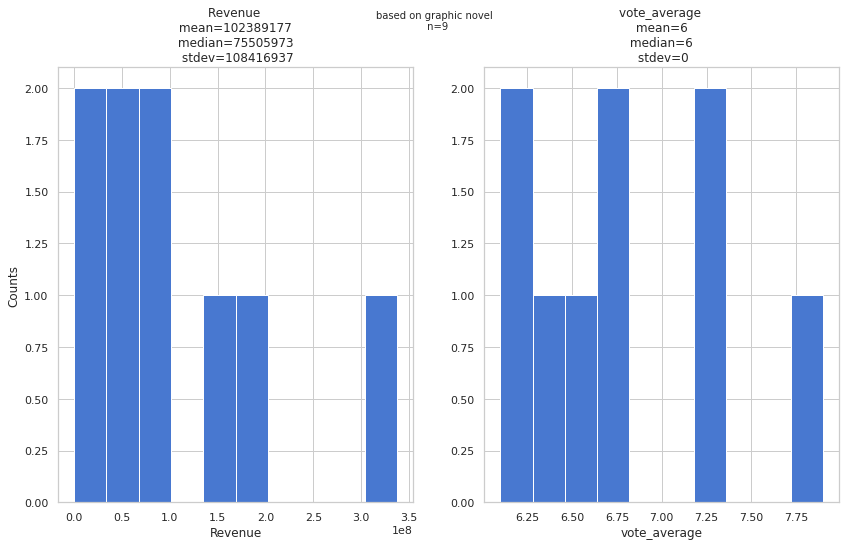

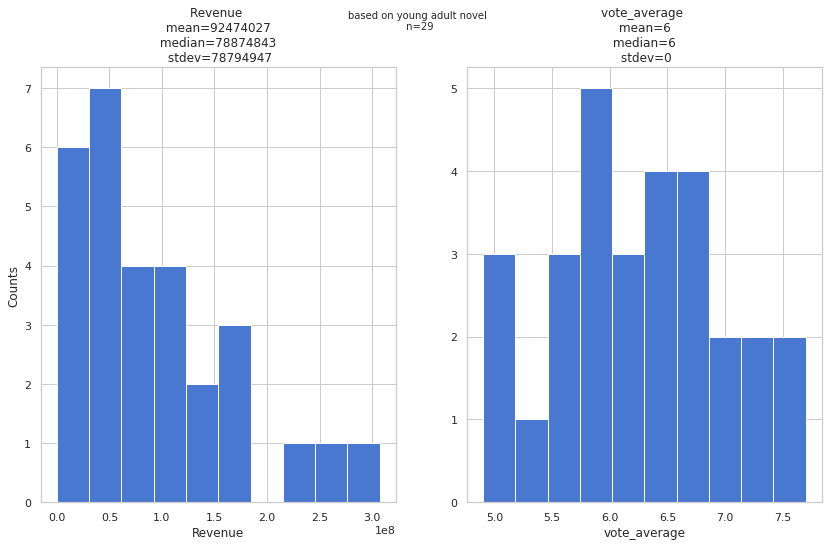

In [17]:
# Additional plots of revenue and vote_average
collect_these = {'keywords': [818, 18712, 223438]}
for collect_type in collect_these.keys():
    for x in collect_these[collect_type]:
        thisgenre_df = retrieve_category(movie_details_neat_trimmed_dict, collect_type, x, 'id', save_dir=plot_dir)
    
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,8))
        ax1 = thisgenre_df['revenue'].hist(ax=ax1)
        ax1.set_title('Revenue \n mean=%d \n median=%d \n stdev=%d' % (thisgenre_df['revenue'].mean(), thisgenre_df['revenue'].median(), thisgenre_df['revenue'].std()))
        ax1.set_ylabel('Counts')
        ax1.set_xlabel('Revenue')

        
        ax2 = thisgenre_df['vote_average'].hist(ax=ax2)
        ax2.set_title('vote_average \n mean=%d \n median=%d \n stdev=%d' % (thisgenre_df['vote_average'].mean(), thisgenre_df['vote_average'].median(), thisgenre_df['vote_average'].std()))
        ax2.set_xlabel('vote_average')
        
        f.suptitle('%s \n n=%d' % (id_maps[collect_type][str(x)], len(thisgenre_df)), fontsize=10)
        plt.savefig(plot_dir+"category_plots_for_novel_revenue_vote_average.png")



In [18]:
#Summary plot with box and whiskers...
for collect_type in collect_these.keys():
    collected_df = pd.DataFrame() # onc column for id relating to genre/category
    collected_df2 = pd.DataFrame()
    for x in collect_these[collect_type]:
        thisgenre_df = retrieve_category(movie_details_neat_trimmed_dict, collect_type, x, 'id', save_dir=plot_dir)
        #id_df = pd.Series([str(x)]*len(thisgenre_df))
        thisgenre_df['id'] = id_maps[collect_type][str(x)]
        collected_df = collected_df.append(thisgenre_df[['profit', 'budget', 'revenue', 'id', 'vote_average']])

        

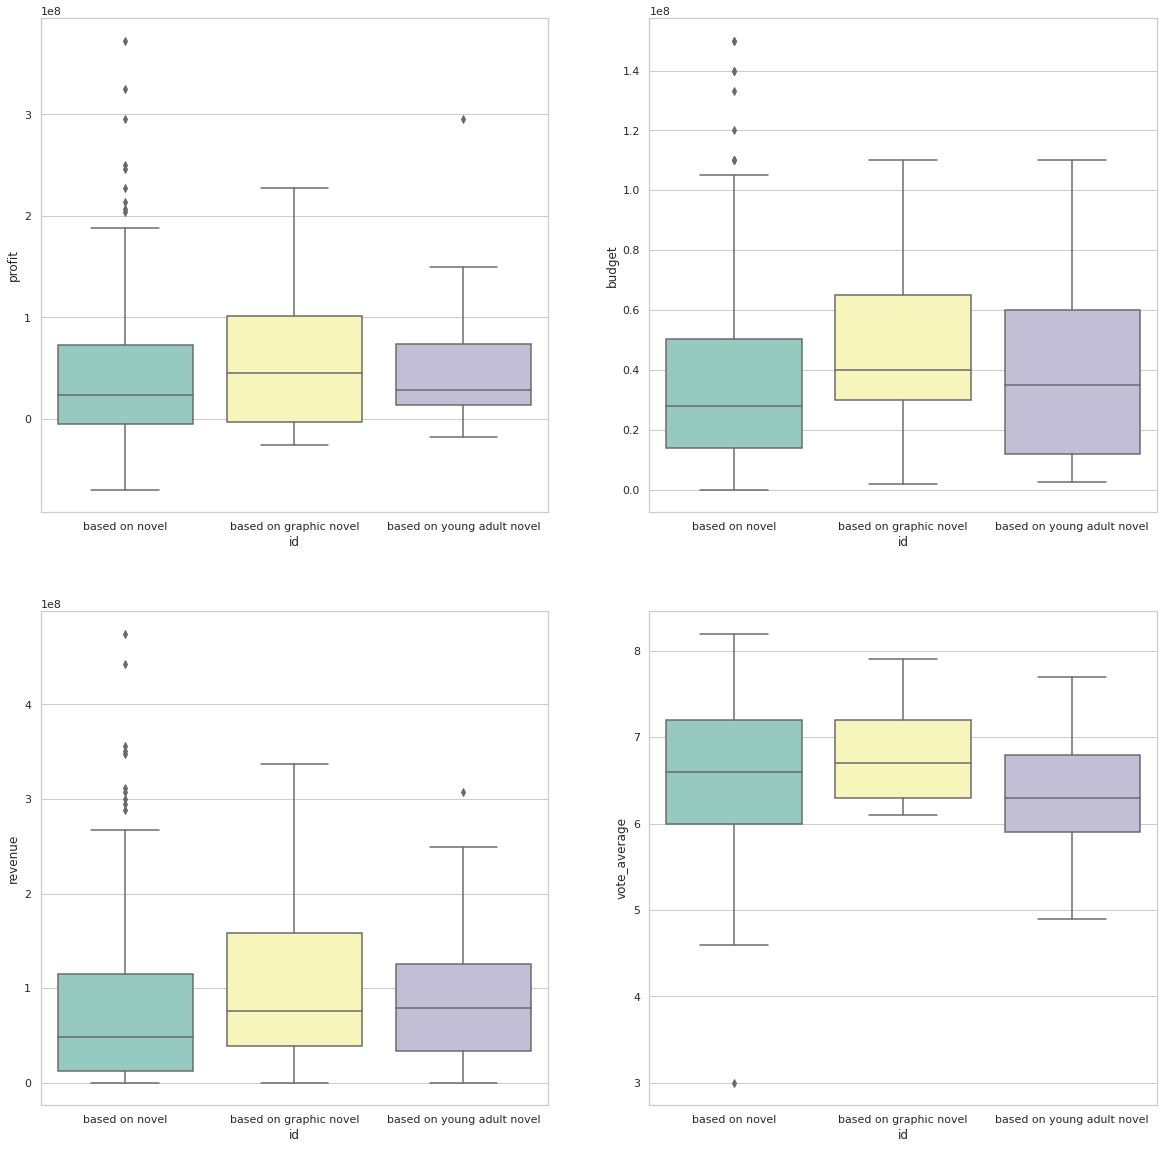

In [19]:
f, ([axis1, axis2],[axis3, axis4]) = plt.subplots(2,2, figsize=(20,20))
sns.boxplot(x="id", y="profit",
                 data=collected_df, palette="Set3", ax=axis1)
sns.boxplot(x="id", y="budget",
                 data=collected_df, palette="Set3", ax=axis2)
sns.boxplot(x="id", y="revenue",
                 data=collected_df, palette="Set3", ax=axis3)
sns.boxplot(x="id", y="vote_average",
                 data=collected_df, palette="Set3", ax=axis4)
plt.savefig(plot_dir+"category_plots_profit-budget-revenue-voteavg_boxplot_different-novel-types.png")